## predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Datasets/Dashboard/Retail_DC_Sales_combined.csv'
df = pd.read_csv(df)

df.head()

,Index,Material,Year_Num,Month_Num,Retail_Value,DC_Value,Product,Unit
0,1,100019,2020,1,46507,0,Triple Antibiotic Oint Md,BOX
1,2,100019,2020,2,43130,42553,Triple Antibiotic Oint Md,BOX
2,3,100019,2020,3,41684,54126,Triple Antibiotic Oint Md,BOX
3,4,100019,2020,4,27444,23942,Triple Antibiotic Oint Md,BOX
4,5,100019,2020,5,25364,22753,Triple Antibiotic Oint Md,BOX


In [3]:
# Add Date column as format datetime
df['Date'] = pd.to_datetime(df['Year_Num'].astype(str) + '-' + df['Month_Num'].astype(str), format='%Y-%m')

# Drop unnecssary columns for forecasting
df.drop(['Year_Num','Month_Num','DC_Value','Unit','Index'], axis=1, inplace=True)

# Drop rows where the 'Retail_Value' column has a value of 0 or null
df = df.dropna(subset=['Retail_Value']).query("Retail_Value != 0")
df.head()

,Material,Retail_Value,Product,Date
0,100019,46507,Triple Antibiotic Oint Md,2020-01-01
1,100019,43130,Triple Antibiotic Oint Md,2020-02-01
2,100019,41684,Triple Antibiotic Oint Md,2020-03-01
3,100019,27444,Triple Antibiotic Oint Md,2020-04-01
4,100019,25364,Triple Antibiotic Oint Md,2020-05-01


In [4]:
# retail value grouped by each date
gdf = df.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-01-01,5486614
1,2020-02-01,5009266
2,2020-03-01,5858805
3,2020-04-01,4917382
4,2020-05-01,4396311


In [5]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-01-01,5486614
2020-02-01,5009266
2020-03-01,5858805
2020-04-01,4917382
2020-05-01,4396311


### Rolling Statistics

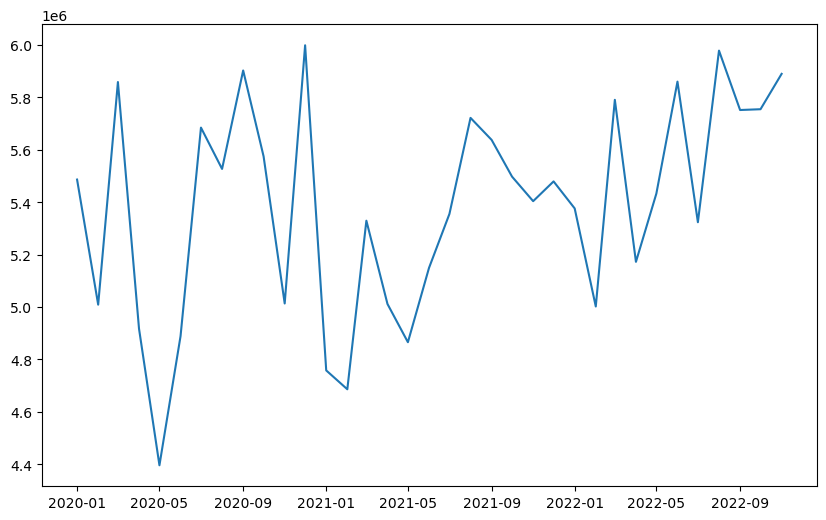

In [6]:
plt.figure(figsize=(10,6))
plt.plot(gdf.index, gdf["Retail_Value"], linestyle="-")
plt.xlabel=('Date')
plt.ylabel=('Retail Value')
plt.show();

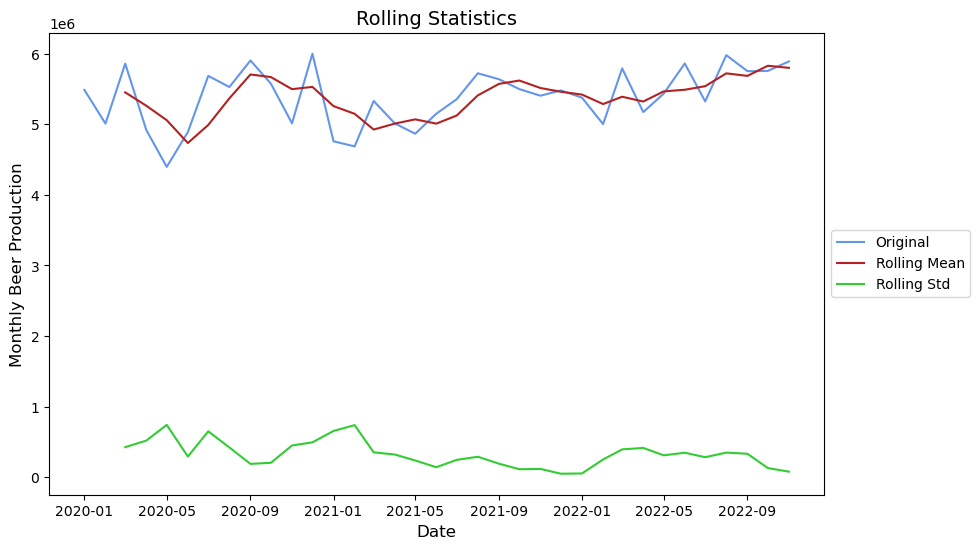

In [7]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Monthly Beer Production', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

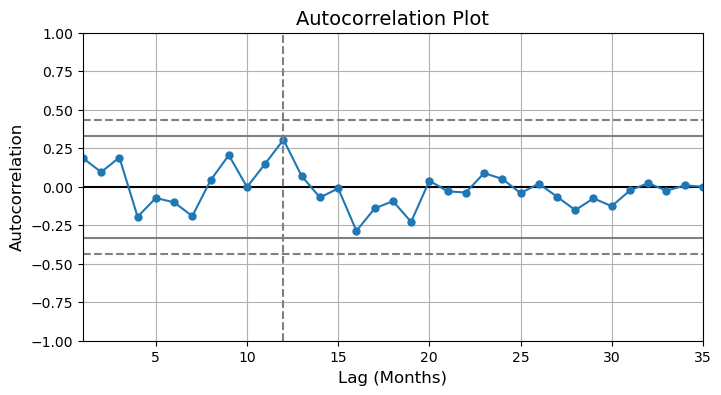

In [8]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

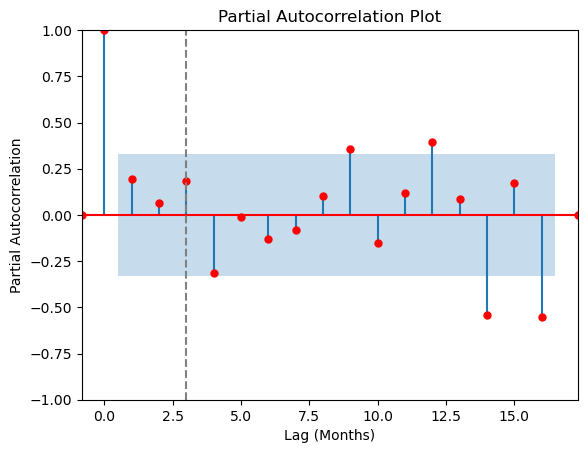

In [9]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

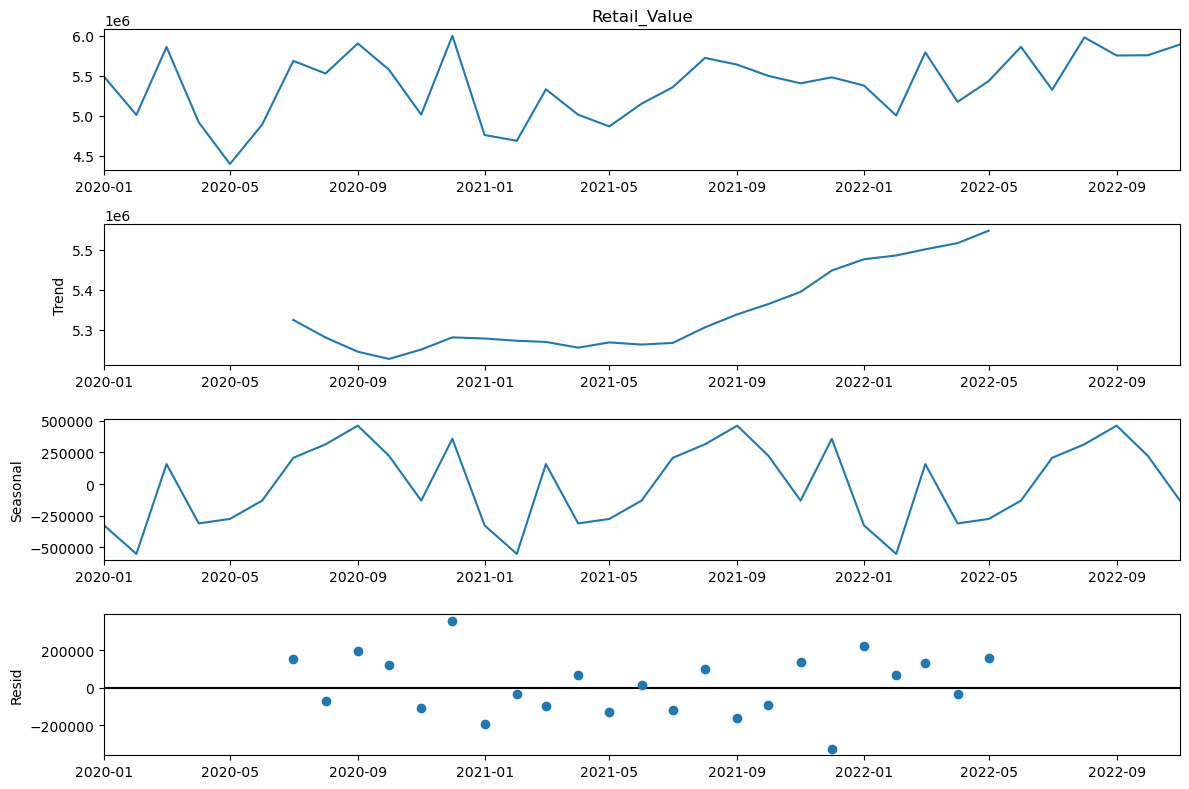

In [10]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

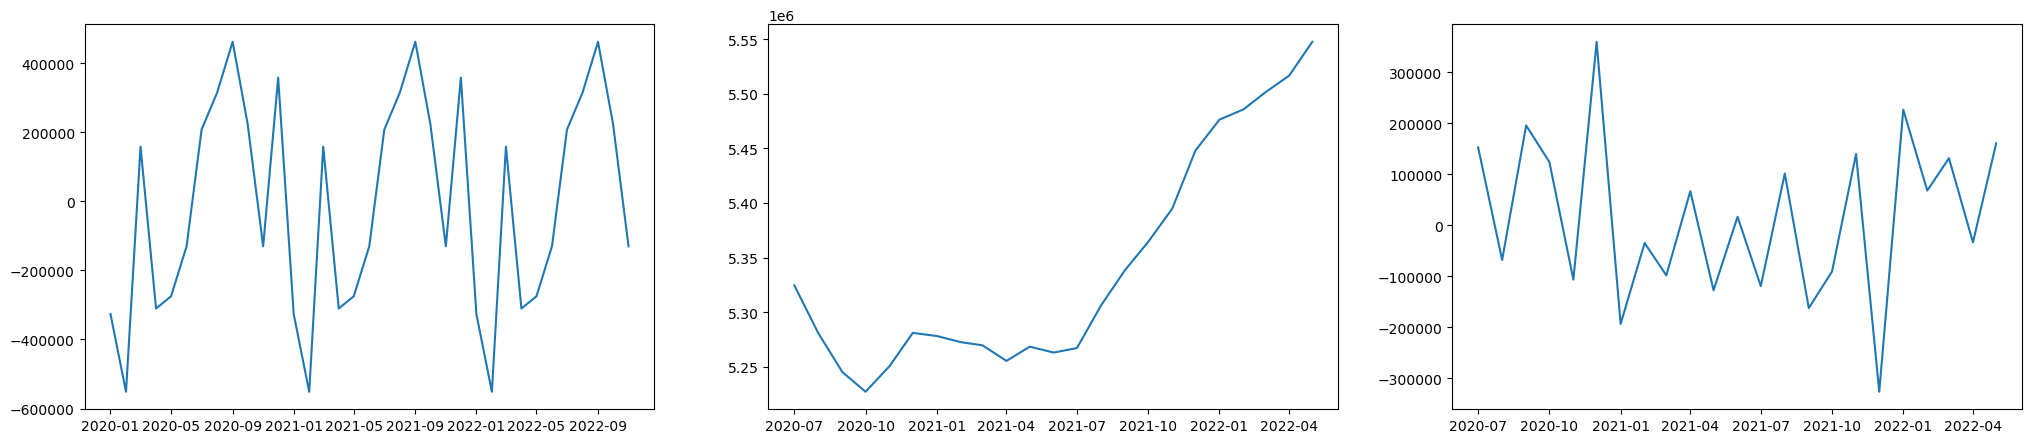

In [11]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [12]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: 0.245
p-value: 0.975
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (3,0,1), seasonal_order = (0,0,1,12))
arima_result = arima_model.fit()
arima_result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35242D+01    |proj g|=  1.53485D+02

At iterate    5    f=  1.45140D+01    |proj g|=  2.74471D-01

At iterate   10    f=  1.43774D+01    |proj g|=  2.70985D-02

At iterate   15    f=  1.43641D+01    |proj g|=  1.69171D-02

At iterate   20    f=  1.43605D+01    |proj g|=  1.51366D-03

At iterate   25    f=  1.43604D+01    |proj g|=  1.10480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Retail_Value   No. Observations:                   35
Model:             SARIMAX(3, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -502.616
Date:                            Wed, 12 Apr 2023   AIC                           1017.231
Time:                                    21:47:02   BIC                           1026.563
Sample:                                01-01-2020   HQIC                          1020.453
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3422      0.202     -1.698      0.090      -0.737       0.053
ar.L2          0.7642      0.204      3.753      0.000       0.365       1.163
ar.L3          0.5708      0.189      3.021      0.003       0.200       0.941
ma.L1          0.9771      0.392      2.492      0.013       0.209       1.746
ma.S.L12       0.4776      0.576      0.829      0.407      -0.651       1.606
sigma2      1.666e+11   2.58e-12   6.45e+22      0.000    1.67e+11    1.67e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.24   Prob(JB):                         0.73
Heteroskedasticity (H):               0.15   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+38. Standard errors may be unstable.
"""

In [14]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-12-01    5.433676e+06
2022-01-01    5.324180e+06
2022-02-01    5.086968e+06
2022-03-01    5.389248e+06
2022-04-01    5.552892e+06
2022-05-01    5.295315e+06
2022-06-01    5.636770e+06
2022-07-01    5.349735e+06
2022-08-01    5.908451e+06
2022-09-01    5.574155e+06
2022-10-01    5.797298e+06
2022-11-01    5.798977e+06
Freq: MS, Name: ARIMA Predictions, dtype: float64

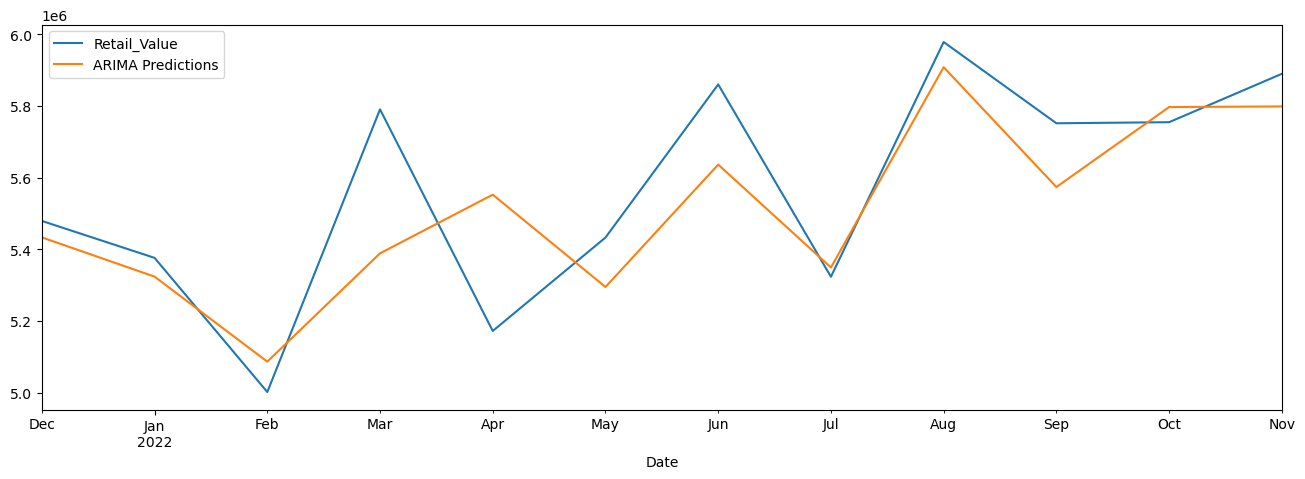

In [15]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [16]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 36187896851.64678
RMSE Error: 190231.166877688
Mean: 5385548.914285715


In [17]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2022-12-01    5.697587e+06
2023-01-01    5.882013e+06
2023-02-01    5.686475e+06
2023-03-01    5.952267e+06
2023-04-01    5.669845e+06
2023-05-01    5.746809e+06
2023-06-01    5.933168e+06
2023-07-01    5.688120e+06
2023-08-01    5.889826e+06
2023-09-01    5.835013e+06
2023-10-01    5.813090e+06
2023-11-01    5.856062e+06
2023-12-01    5.811531e+06
Freq: MS, Name: ARIMA Predictions, dtype: float64

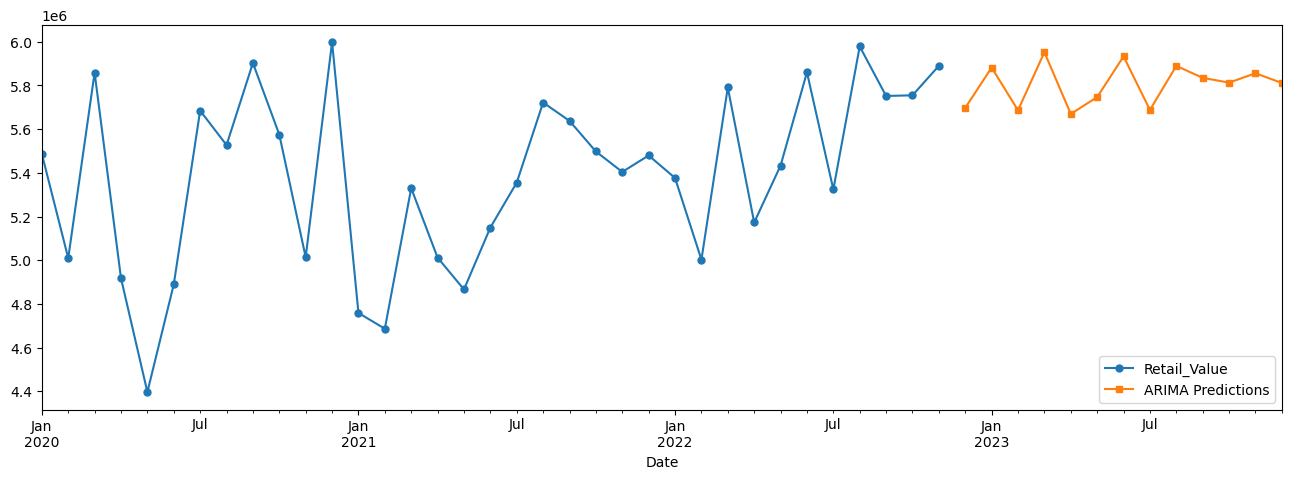

In [18]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [19]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2022-12-01,5.697587e+06
2023-01-01,5.882013e+06
2023-02-01,5.686475e+06
2023-03-01,5.952267e+06
2023-04-01,5.669845e+06


In [21]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [22]:
udf.head()

,Date,Retail_Value
0,2020-01-01,5486614.0
1,2020-02-01,5009266.0
2,2020-03-01,5858805.0
3,2020-04-01,4917382.0
4,2020-05-01,4396311.0


In [23]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model.csv', index=False)